# Hi-C matrix comparison

Compute a Hi-C contact map from structure TSVs and compare it to the reference Hi-C matrix stored in the same folder.

In [181]:
import math
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


In [182]:
ORIGINAL_RMS = 11.1462
NORMALIZED_RMS = 1.1525

# Directory containing sample_*.tsv structures and <dirname>_sim_hic_freq.tsv reference
samples_dir = Path("outputs/dit_samples/CrossDiT-S/Pair_75_sim_hic_freq")

# Hi-C contact options
# r_cutoff = 3.0 / (ORIGINAL_RMS / NORMALIZED_RMS)  # in normalized space
r_cutoff = 3.0 / (9.744)
soft_kernel = True  # use exp(-d/lengthscale); set False for hard cutoff
lengthscale = None  # None -> use r_cutoff
bin_kb = 5.0


In [183]:
def coords_from_tsv(path: str) -> pd.DataFrame:
    df = pd.read_csv(path, sep="	")
    df = df.drop(columns=[c for c in df.columns if c.startswith("bead_index")], errors="ignore")
    expected = ["hic_index", "x1", "y1", "z1", "mask1", "x2", "y2", "z2", "mask2"]
    missing = [c for c in expected if c not in df.columns]
    if missing:
        raise ValueError(f"{path}: missing columns {missing}")

    recs = []
    m1 = df["mask1"] >= 0.5
    if m1.any():
        recs.append(pd.DataFrame({"hic_index": df.loc[m1, "hic_index"].values, "x": df.loc[m1, "x1"].values, "y": df.loc[m1, "y1"].values, "z": df.loc[m1, "z1"].values}))
    m2 = df["mask2"] >= 0.5
    if m2.any():
        recs.append(pd.DataFrame({"hic_index": df.loc[m2, "hic_index"].values, "x": df.loc[m2, "x2"].values, "y": df.loc[m2, "y2"].values, "z": df.loc[m2, "z2"].values}))
    if not recs:
        raise ValueError(f"{path}: no beads with mask1 or mask2 == 1")

    beads = pd.concat(recs, ignore_index=True)
    coords = beads.groupby("hic_index")[['x', 'y', 'z']].mean().sort_index()
    return coords


def hic_from_structures(tsv_paths, r_cutoff: float = 3.0, soft: bool = True, lengthscale: float | None = None):
    if not tsv_paths:
        raise ValueError("No TSV files provided")
    coords_list = [coords_from_tsv(p) for p in tsv_paths]
    base_index = coords_list[0].index.to_numpy()
    for p, c in zip(tsv_paths[1:], coords_list[1:], strict=False):
        if not np.array_equal(c.index.to_numpy(), base_index):
            raise ValueError(f"hic_index mismatch between {tsv_paths[0]} and {p}")

    n = len(base_index)
    counts = np.zeros((n, n), dtype=float)
    if lengthscale is None:
        lengthscale = r_cutoff

    for coords in coords_list:
        pos = coords[['x', 'y', 'z']].to_numpy()
        diffs = pos[:, None, :] - pos[None, :, :]
        dists = np.linalg.norm(diffs, axis=-1)
        if soft:
            w = np.exp(-dists / lengthscale)
            np.fill_diagonal(w, 0.0)
            counts += w
        else:
            contact = (dists <= r_cutoff).astype(float)
            np.fill_diagonal(contact, 0.0)
            counts += contact

    freq = counts / len(coords_list)
    return freq, base_index


def load_hic_matrix_tsv(path: str) -> np.ndarray:
    df = pd.read_csv(path, sep="	")
    if "hic_index" in df.columns:
        df = df.drop(columns=["hic_index"])
    else:
        n_rows, n_cols = df.shape
        if n_cols == n_rows + 1:
            first_col = df.iloc[:, 0]
            if np.array_equal(first_col.to_numpy(), np.arange(n_rows)):
                df = df.iloc[:, 1:]
    mat = df.to_numpy(dtype=float)
    if mat.shape[0] != mat.shape[1]:
        raise ValueError(f"Matrix is not square after parsing: shape={mat.shape}")
    return mat


def log_transform(mat: np.ndarray) -> np.ndarray:
    nonzero = mat[mat > 0]
    eps = nonzero.min() * 0.1 if nonzero.size else 1e-6
    return np.log10(np.maximum(mat, eps))


Found 500 sample TSVs in outputs\dit_samples\CrossDiT-S\Pair_75_sim_hic_freq
Copied test ref Hi-C from data\test\Pair_75\Pair_75_sim_hic_freq.tsv to outputs\dit_samples\CrossDiT-S\Pair_75_sim_hic_freq\Pair_75_sim_hic_freq.tsv
Reference matrix: outputs\dit_samples\CrossDiT-S\Pair_75_sim_hic_freq\Pair_75_sim_hic_freq.tsv
hic_ref max: 0.92 freq_struct max: 0.6607401296519153
vmin: -3.5120385690318185 vmax: -0.036212172654444715
hic_ref_log min/max: -2.3979400086720375 -0.036212172654444715
freq_struct_log min/max: -3.5120385690318185 -0.1799693157781288


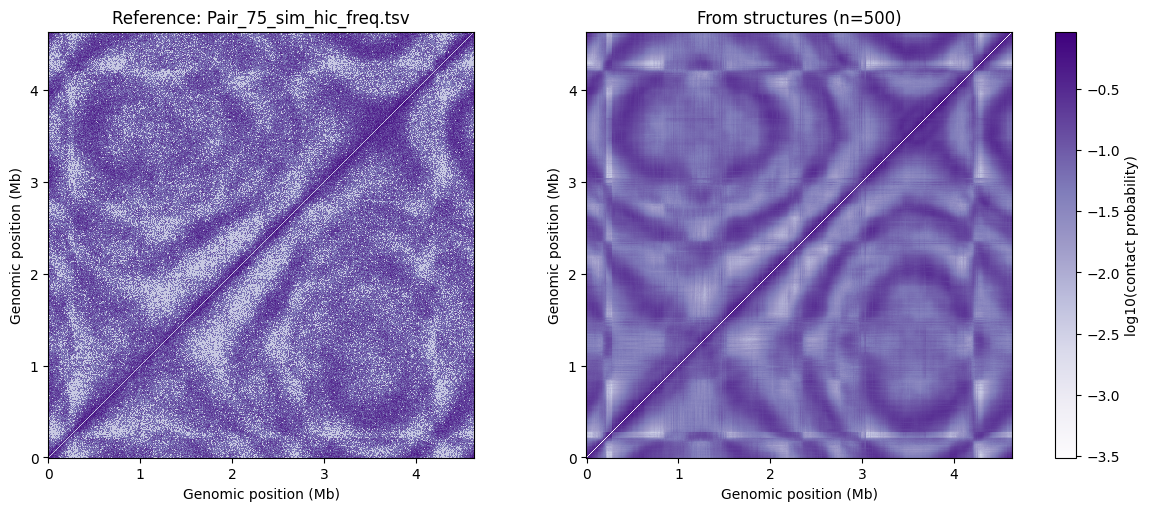

Saved generated Hi-C matrix to outputs\dit_samples\CrossDiT-S\Pair_75_sim_hic_freq\Pair_75_sim_hic_freq_gen.tsv


In [184]:
struct_paths = sorted(samples_dir.glob("sample_*.tsv"))
print(f"Found {len(struct_paths)} sample TSVs in {samples_dir}")
if not struct_paths:
    raise FileNotFoundError(f"No sample_*.tsv files in {samples_dir}")

freq_struct, hic_index = hic_from_structures(
    struct_paths, r_cutoff=r_cutoff, soft=soft_kernel, lengthscale=lengthscale
)

# Copy test ref Hi-C into samples_dir if available
pair_id = samples_dir.name.split("_sim_hic_freq")[0]
test_ref = Path("data/test") / pair_id / f"{pair_id}_sim_hic_freq.tsv"
dest_ref = samples_dir / f"{samples_dir.name}.tsv"
if test_ref.exists():
    dest_ref.parent.mkdir(parents=True, exist_ok=True)
    dest_ref.write_bytes(test_ref.read_bytes())
    print(f"Copied test ref Hi-C from {test_ref} to {dest_ref}")
ref_path = samples_dir / f"{samples_dir.name}.tsv"
print(f"Reference matrix: {ref_path}")
if not ref_path.exists():
    raise FileNotFoundError(f"Reference Hi-C not found at {ref_path}")
hic_ref = load_hic_matrix_tsv(ref_path)
hic_ref = np.minimum(hic_ref, 1.0)

if freq_struct.shape != hic_ref.shape:
    raise ValueError(f"Shape mismatch: computed {freq_struct.shape} vs reference {hic_ref.shape}")

print("hic_ref max:", hic_ref.max(), "freq_struct max:", freq_struct.max())
hic_ref_log = log_transform(hic_ref)
freq_struct_log = log_transform(freq_struct)
vmin = min(hic_ref_log.min(), freq_struct_log.min())
vmax = max(hic_ref_log.max(), freq_struct_log.max())

print('vmin:', vmin, 'vmax:', vmax)
print('hic_ref_log min/max:', hic_ref_log.min(), hic_ref_log.max())
print('freq_struct_log min/max:', freq_struct_log.min(), freq_struct_log.max())

n = hic_ref.shape[0]
genome_mb = n * bin_kb / 1000.0
tick_mb = np.arange(0, math.floor(genome_mb) + 1, 1.0)
tick_pos = (tick_mb * 1000.0 / bin_kb).astype(int)

fig, axes = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)
im0 = axes[0].imshow(hic_ref_log, cmap="Purples", origin="lower", vmin=vmin, vmax=vmax, interpolation="nearest")
axes[0].set_title(f"Reference: {ref_path.name}")
axes[1].imshow(freq_struct_log, cmap="Purples", origin="lower", vmin=vmin, vmax=vmax, interpolation="nearest")
axes[1].set_title(f"From structures (n={len(struct_paths)})")

for ax in axes:
    ax.set_xlabel("Genomic position (Mb)")
    ax.set_ylabel("Genomic position (Mb)")
    ax.set_xticks(tick_pos)
    ax.set_xticklabels([f"{m:g}" for m in tick_mb])
    ax.set_yticks(tick_pos)
    ax.set_yticklabels([f"{m:g}" for m in tick_mb])

cbar = fig.colorbar(im0, ax=axes.ravel().tolist(), fraction=0.046, pad=0.04)
cbar.set_label("log10(contact probability)")
plt.show()

# Save generated Hi-C matrix after plotting
out_path = ref_path.with_name(f"{ref_path.stem}_gen{ref_path.suffix}")
df_out = pd.DataFrame(freq_struct, columns=hic_index)
df_out.insert(0, "hic_index", hic_index)
df_out.to_csv(out_path, sep="\t", index=False)
print(f"Saved generated Hi-C matrix to {out_path}")


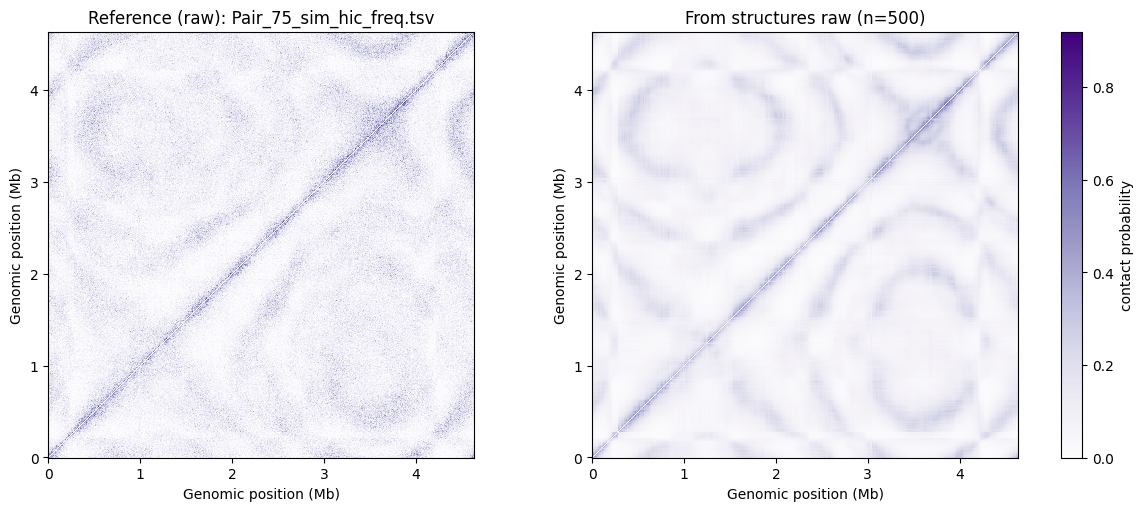

In [185]:
# Plot matrices without log10
vmin_raw = min(hic_ref.min(), freq_struct.min())
vmax_raw = max(hic_ref.max(), freq_struct.max())

fig, axes = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)
im0 = axes[0].imshow(hic_ref, cmap="Purples", origin="lower", vmin=vmin_raw, vmax=vmax_raw, interpolation="nearest")
axes[0].set_title(f"Reference (raw): {ref_path.name}")
axes[1].imshow(freq_struct, cmap="Purples", origin="lower", vmin=vmin_raw, vmax=vmax_raw, interpolation="nearest")
axes[1].set_title(f"From structures raw (n={len(struct_paths)})")

for ax in axes:
    ax.set_xlabel("Genomic position (Mb)")
    ax.set_ylabel("Genomic position (Mb)")
    ax.set_xticks(tick_pos)
    ax.set_xticklabels([f"{m:g}" for m in tick_mb])
    ax.set_yticks(tick_pos)
    ax.set_yticklabels([f"{m:g}" for m in tick_mb])

cbar = fig.colorbar(im0, ax=axes.ravel().tolist(), fraction=0.046, pad=0.04)
cbar.set_label("contact probability")
plt.show()
